# "Single-column" set for Test 3: ecRad input file creation.

### Test 3: Ice Water Path (IWP)

#### Version 7a: 2024-08-01

Preparing matrix of 1D columns .nc file and formatting for input ecRad file (Useful for TripleClouds Solver)

Fixed parameters:
1. Radiative Transfer Model: ecRad.
2. Tropical sounding (Lapse Rate of $6.7\;K/km$ (see on next cells below)).
3. Cosine of solar zenith angle: $\mu = 0.6$ (effective solar zenith angle of $53^{\circ}$, Wallace&Hobbs, 2006).
4. SW albedo: $\alpha = 0.05$ (Hartmann & Berry, 2017).
5. LW emissivity: $\epsilon = 0.97$ (REFERENCE?).
6. Skin temperature as surface temperature: $T_{skin} = 300 K$ (290 to 300 K (Jin & Dickinson, 2010)).
7. Gases: CO$_2$ = 390.1ppm, CH$_4$ = 1.8ppm, N$_2$O = 322ppb, O$_2$ = 0.20942ppm, from 2012 climatology used in ICON run scripts.
8. No liquid water.
9. No aerosols.
10. Solver: Tripleclouds.

Variable parameters:
1. Macro: Temperature (Altitude-position) = 236 K, 218 K and 201 K for cloud middle level.
2. Macro: Geometrical Depth $\Delta h = 1.5 km$.
3. Macro (<b>TEST 3</b>): Ice Water Path (IWP) = 0.1:1000 in logscale (2000 elements) $g/m^2$ (For Sokol & Hartmann 2020, the IWP change until 1000 $gm^{-2}$):

    $$IWP \;=\; \int{IWC\;dz} \;=\; \int_{h_1}^{h_2}{q_i\;\rho(z)\;dz}\;\;\; , \;\;\;(h_2 - h_1 = 1.5 \;km)$$

    where IWC is the Ice Water Content $(g/m^3)$, which is the Ice Water Mixing Ratio $q_{i}\;(g/km)$ times the density $\rho(z)$:

    $$\Rightarrow\;q_i = \frac{IWP}{\int_{h_1}^{h_2}{\rho(z)\;dz}}$$
4. Micro: Effective Radius $r_e$ = 30 $\mu m$ (Hartmann & Berry, 2017).
5. Ice Optical Schemes (index associated with config file):
        5.1 Fu 1996 and Fu, Yang & Sun 1998 (1O).
        5.2 Yi et al. 2013 (2O).
        5.3 Baran et al. 2016 (3O).
        5.4 Baran et al. 2014 (4O).

### Loading Libraries

In [1]:
import numpy as np # Version used here: 1.23.4 (python 3.8.15)
import pandas as pd # Version used here: 1.5.2 (python 3.8.15)
import xarray as xr # Version used here: 2022.11.0 (python 3.8.15)
from scipy import interpolate # Version used here: 1.10.0 (python 3.8.15)

import matplotlib.pyplot as plt # Version used here: 3.6.2 (python 3.8.15)
from matplotlib import cm

%matplotlib notebook

## Checking Tropical Sounding

Directories from UofArizona HPC server:

In [2]:
tropical_profile = pd.read_csv('tropical_profile_ellingson_250m.txt', sep = '\s+ ', engine = 'python')

In [3]:
temp            = tropical_profile['temperature (K)'].iloc[::-1]
altitude        = tropical_profile['height (km)'].iloc[::-1] # If this is over sea level, we can use altitude.
tropopause_i    = temp.argmin()
tropopause      = temp.iloc[tropopause_i]
melting_layer_i = (temp - 273.15).abs().argmin()
melting_layer   = temp.iloc[melting_layer_i]

print('Tropopause: ', tropopause, ' K at ', altitude.iloc[tropopause_i], ' km')
print('Melting Layer: ', altitude.iloc[melting_layer_i], ' km')

Tropopause:  195.6  K at  17.0  km
Melting Layer:  4.75  km


### Density Profile $(kg/m^3)$

In [4]:
R       = 287 # J/kgK
density = (tropical_profile['pressure (hPa)']*100)/(tropical_profile['temperature (K)']*R)
density = density.iloc[::-1]

Estiamting Lapse Rate:

In [5]:
DT = tropical_profile['temperature (K)'][30] - tropical_profile['temperature (K)'][20]
Dh = tropical_profile['height (km)'][30] - tropical_profile['height (km)'][20]
slope = DT/Dh
print('Lapse Rate: ',slope,' K/km')

Lapse Rate:  -6.7  K/km


## Preparing input table

List of parameters:

- Skin Temperature (for each temperature-perturbation level)
- cos_solar_zenith_angle (for each temperature-perturbation level)
- pressure_hl (half level column)
- temperature_hl (half level column)
- q or h2o_mmr (Specific Humidity (kg/kg)) (level column)
- o3_mmr (Ozone Mass Mixing Ratio (kg/kg)) (level column)
- co2_vmr (mol/mol) (scalar)
- ch4_vmr (mol/mol) (scalar)
- n2o_vmr (mol/mol) (scalar)
- o2_vmr (mol/mol) (scalar)
- q_liquid (Liquid cloud mass mixing ratio (kg/kg)) (level column)
- q_ice (Ice cloud mass mixing ratio (kg/kg)) (level column)
- re_liquid (m) (level column)
- re_ice (m) (level column)
- cloud_fraction (level column)
- sw_albedo (1 value)
- lw_emissivity (1 value)

### 1. Half Level Pressures (Pa)

"The half_level dimension corresponds to the mid-points of the levels, plus the top-of-atmosphere and surface, and so must be one more than level"

In [6]:
pressure_hli = [tropical_profile['pressure (hPa)'].iloc[-1]*100] # Pa
for i in range(len(tropical_profile['pressure (hPa)'])-1):
    pif = tropical_profile['pressure (hPa)'].iloc[-1-(i+1)]*100
    pii = tropical_profile['pressure (hPa)'].iloc[-1-i]*100
    pressure_hli.append((pif+pii)/2)
pressure_hli.append(tropical_profile['pressure (hPa)'].iloc[0]*100) # Pa

### 2. Half Level Temperatures (K)

Interpolation obtained from half level pressures:

In [7]:
temp_int        = interpolate.interp1d(tropical_profile['pressure (hPa)'].iloc[::-1]*100,
                                       tropical_profile['temperature (K)'].iloc[::-1])
temperature_hli = temp_int(pressure_hli)

### 3. Table

IWP from .1 to 1000 every .1 $g/m^2$ for Logarithmic display

In [8]:
iwp  = np.logspace(np.log10(.1),np.log10(1000), 2000)
rows = len(iwp)
print(rows)

2000


<IPython.core.display.Javascript object>


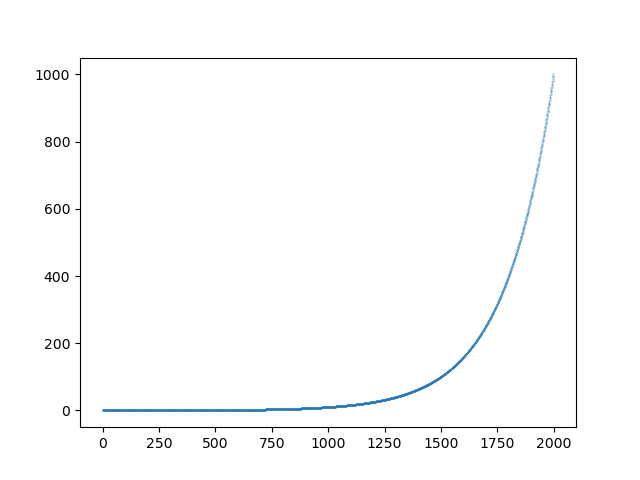

In [9]:
plt.figure()
plt.plot(iwp, '.', markersize = 0.5)

Level of perturbation (236 K, 218 K, 201 K) with 1.5 km cloud depth:

In [10]:
# Fixed parameters:
cos_solar_zenith_angle = np.full(rows, .6)
lw_emissivity          = np.full(rows, .97)
sw_albedo              = np.full(rows, .05)
skin_temperature       = np.full(rows, temp.iloc[-1]) # 300 K from surface temperature [K]

re = 30 # Effective radious [um]

# Specific humidity matrix (perturbations X level):
qi = tropical_profile['specific hum\t(kg/kg)'].iloc[::-1]
q  = np.full((rows, len(pressure_hli)-1), qi)

# Gases as one scalar (from current ICON running in levante, representative for 2012 values)
co2_vmr = 390.1e-6 # Volume mixing ratio mol mol^-1
ch4_vmr = 1.8e-6   # Volume mixing ratio mol mol^-1
n2o_vmr = 322e-9   # Volume mixing ratio mol mol^-1
o2_vmr  = 0.20946  # Volume mixing ratio mol mol^-1

# Ozone mass mixing ratio matrix (perturbations X level):
o3_mmr = np.zeros((rows, len(pressure_hli)-1))

# Liquid cloud mass mixing ratio (perturbations X level):
q_liquid = np.zeros((rows, len(pressure_hli)-1))

# Liquid cloud effective radius (m):
# (default value from Hogan's practical exercise, this is ignored as there is no liquid cloud):
re_liquid = np.full((rows, len(pressure_hli)-1), 1e-5)

# Ice cloud effective radius (m):
re_ice = np.full((rows, len(pressure_hli)-1), re*1e-6)

# Half Level Pressures (perturbations X half_level):
pressure_hl = np.full((rows, len(pressure_hli)), pressure_hli)

# Half Level Temperatures (perturbations X half_level):
temperature_hl = np.full((rows, len(pressure_hli)), temperature_hli)

# CREATING THE ICE WATER MIXING RATIO PROFILE FOR EACH PERTURBATION LEVEL:
perturbations_temp = [236, 218, 201]
for pert_tempi in perturbations_temp:
    # Ice cloud mass mixing ratio (perturbations X level):
    globals()['q_ice_'+str(pert_tempi)]          = np.zeros((rows, len(pressure_hli)-1))
    globals()['cloud_fraction_'+str(pert_tempi)] = np.zeros((rows, len(pressure_hli)-1))
    
    perturbation_i        = (temp.iloc[tropopause_i:] - pert_tempi).abs().argmin() # iloc position
    perturbation_altitude = altitude.iloc[tropopause_i + perturbation_i]
    # loc position: lower_limit_hi = altitude[altitude==(perturbation_altitude - .75)].index[0]
    # loc position: upper_limit_hi = altitude[altitude==(perturbation_altitude + .75)].index[0]
    # iloc position of bottom layer:
    bottom_hi = altitude.index.get_loc(altitude[altitude == (perturbation_altitude - .75)].index[0])
    # iloc position of top layer:
    top_hi    = altitude.index.get_loc(altitude[altitude == (perturbation_altitude + .75)].index[0])
    
    # Integration layer (or cloud position for 1.5 km depth) from TOP to BOTTOM:
    integral  = abs(np.trapz(density.iloc[top_hi:bottom_hi+1],
                             altitude.iloc[top_hi:bottom_hi+1]*1000, 0.1))
    
    for i in range(rows): # columns with vertical profiles ("level" dimension for final matrix)
        qi = (iwp[i] / integral)*1e-3 # qi = IWP / int(rho dz) [kg/kg]
        for j in range(len(altitude)):
            if j >= tropopause_i:
                hj = altitude.iloc[j]
                if hj >= (perturbation_altitude - .75) and hj <= (perturbation_altitude + .75):
                        eval('q_ice_'+str(pert_tempi))[i,j]          = qi
                        eval('cloud_fraction_'+str(pert_tempi))[i,j] = 1

#### Figure S11

In [11]:
iwp_sel_index = []
for seli in [10, 50, 100, 250, 500, 750, 1000]:
    iwp_sel_index.append(np.argmin(np.abs(np.array(iwp) - seli)))
iwp[iwp_sel_index] # here is your result

array([   9.97698915,   50.04373029,   99.88487947,  249.86121611,
        501.01407301,  751.51554612, 1000.        ])

<IPython.core.display.Javascript object>


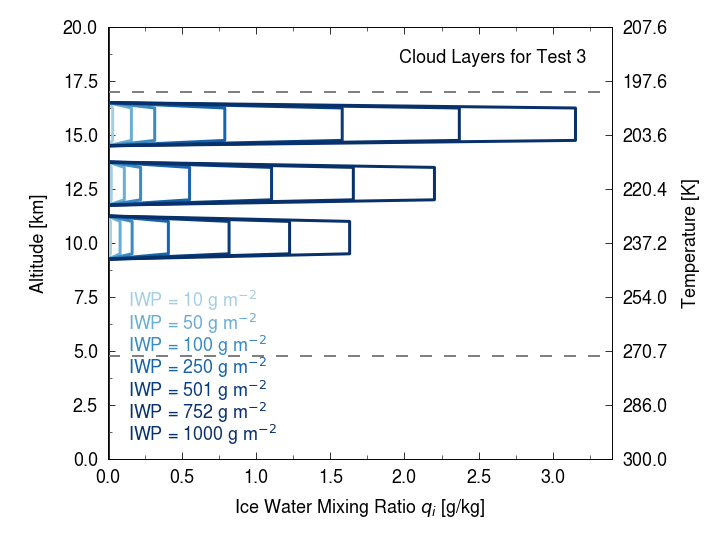

In [12]:
fontname  = 'Nimbus Sans'
fontsize  = 18
my_colors = [(107/255,188/255,233/255), (88/255,148/255,197/255), 
            (131/255,170/255,69/255), (229/255,179/255,69/255), (202/255,91/255,46/255),
            (169/255,23/255,38/255),
            (116/255,24/255,123/255), 'grey']
flength   = 10       # inches
fheigth   = flength*.75 # inches
f, ax     = plt.subplots(figsize = (flength, fheigth), dpi=72)
plt.subplots_adjust(top = 0.95, bottom = 0.15, left = 0.15, right = 0.85)

perturbations_temp = [201,218,236]
alpha = 1
for pert_tempi in perturbations_temp:
    handles = []
    labels  = []
    counter = 0
    #if perturbations_temp.index(pert_tempi) > 0: alpha = 1
    for i in iwp_sel_index:#[99]#[99,499]#[99,499,999]#[99,499,999,1499]#[99,499,999,1499,1999]
        h1 = ax.plot(eval('q_ice_'+str(pert_tempi))[i]*1000, 
                     tropical_profile['height (km)'].iloc[::-1],
                     linestyle = 'solid', linewidth = 3,
                     color = cm.Blues(.35 + counter*.15),
                    alpha = alpha)
        counter += 1
        handles = handles + h1
        if i == 0: iwpi = str(iwp[i].round(1))
        else: iwpi = str(int(iwp[i].round(0)))
        labels.append('IWP = ' + iwpi + r' g m$^{-2}$')
        
melting_layer_h = tropical_profile['height (km)'].iloc[::-1].iloc[melting_layer_i]
h2 = ax.axhline(y = melting_layer_h, linestyle = 'dashed', color = 'grey',
                dashes = (6, 6), linewidth  =2)
tropopause_h = tropical_profile['height (km)'].iloc[::-1].iloc[tropopause_i]
h3 = ax.axhline(y = tropopause_h, linestyle = 'dashed', color = 'grey',
                dashes = (6, 6), linewidth  =2)

#ax.grid('on', linestyle = 'dashed', color = 'grey',
#        dashes = (25, 25), linewidth = .3)

# X Axis:
ax.set_xlabel(r'Ice Water Mixing Ratio $q_{i}$ [g/kg]', 
              fontname = fontname, fontsize = fontsize,
              color = 'black', labelpad = 10)
major_ticks_x = np.arange(-.5, 4, .5)
minor_ticks_x = np.arange(-.5, 4, .25)
ax.set_xticks(major_ticks_x)
ax.set_xticks(minor_ticks_x, minor=True)
ax.set_xlim(0, 3.4)
ax.tick_params(axis = 'x', which = 'major', color = 'black',
               size = 7, direction = 'in', top = True,
               labelsize = fontsize, pad=10)
ax.tick_params(axis = 'x', which = 'major', color = 'black',
               size = 7, direction = 'in', top = True,
               labelsize = fontsize, pad = 10)
ax.tick_params(axis = 'x', which = 'minor',
               color = 'black', size = 4,
               direction = 'in', top = True)
for tick in ax.get_xticklabels():
    tick.set_fontname(fontname)

# Y Axis:
ax.set_ylabel('Altitude [km]', 
              fontname = fontname, fontsize = fontsize,
              color = 'black', labelpad = 15)
major_ticks_y = np.arange(-20, 30, 2.5)
minor_ticks_y = np.arange(-20, 30, 1.25)
ax.set_yticks(major_ticks_y)
ax.set_yticks(minor_ticks_y, minor=True)
ax.set_ylim(0, 20)
ax.tick_params(axis = 'y', which = 'major', color = 'black',
               size = 7, direction = 'in', right = True,
               labelsize = fontsize, pad = 10)
ax.tick_params(axis = 'y', which = 'minor',
               color = 'black', size = 4,
               direction = 'in', top = True)
for tick in ax.get_yticklabels():
    tick.set_fontname(fontname)
#ax.tick_params(axis = 'y', which = 'minor', color = 'black',
#               size = 4, direction = 'in', right = True)

# Right Y Axis:
ax2 = ax.twinx()
ax2.set_ylabel('Temperature [K]',
               fontname = fontname, fontsize = fontsize,
               color = 'black', labelpad = 15)
yticklabels1 = np.arange(0, 22.5, 2.5) # default altitude tick labels
yticklabels2 = tropical_profile['temperature (K)'].loc[tropical_profile['height (km)'].isin(yticklabels1)].round(1).to_list()    
ax2.set_yticks(yticklabels1)
ax2.set_yticklabels(yticklabels2)
ax2.tick_params(axis = 'y', which = 'major', color = 'black',
                size = 7, direction = 'in', right = True,
                labelsize = fontsize, pad = 10)
ax2.tick_params(axis = 'x', which = 'minor',
                color = 'black', size = 4,
                direction = 'in', top = True)
for tick in ax2.get_yticklabels():
    tick.set_fontname(fontname)

ax.text(0.95, 0.95, 'Cloud Layers for Test 3',
        fontname = fontname, fontsize = fontsize,
        color = 'black',
        ha = 'right', va = 'top', transform = ax.transAxes)

# Legend:
#handles = h1 + h2 + h3 + h4
#labels  = ['200 K','212 K','224 K','236 K']    
legend = plt.legend(handles, labels, loc = 'lower left', bbox_to_anchor = (-.01, -.01),
                    frameon = False, ncol = 1, columnspacing = 1,
                    labelspacing = -.1, labelcolor = 'linecolor',
                    handlelength = 0, handletextpad = .5,
                    prop = {'family': fontname, 'size': fontsize})

# Save Figure:
plt.savefig('paper_figures/fs11_1000.pdf', dpi = 300)

In [16]:
iwp_sel_index = []
for seli in [10, 50, 100, 150, 200]:
    iwp_sel_index.append(np.argmin(np.abs(np.array(iwp) - seli)))
iwp[iwp_sel_index] # here is your result

array([  9.97698915,  50.04373029,  99.88487947, 149.82621005,
       200.28610711])

<IPython.core.display.Javascript object>


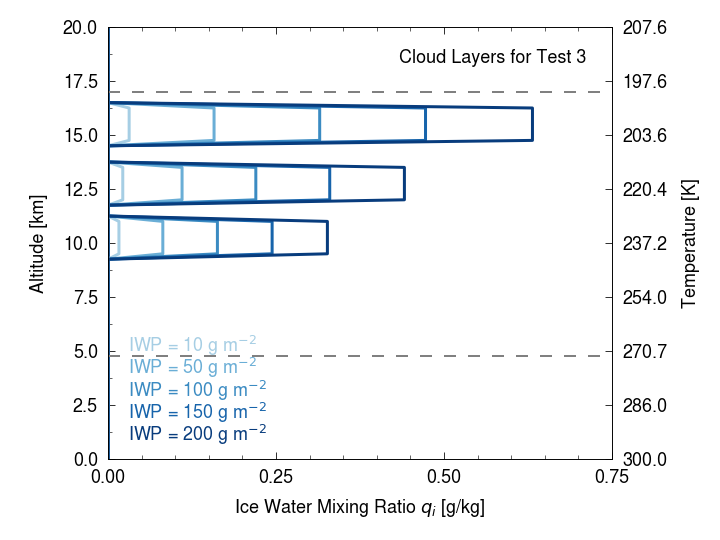

In [17]:
fontname  = 'Nimbus Sans'
fontsize  = 18
my_colors = [(107/255,188/255,233/255), (88/255,148/255,197/255), 
            (131/255,170/255,69/255), (229/255,179/255,69/255), (202/255,91/255,46/255),
            (169/255,23/255,38/255),
            (116/255,24/255,123/255), 'grey']
flength   = 10       # inches
fheigth   = flength*.75 # inches
f, ax     = plt.subplots(figsize = (flength, fheigth), dpi=72)
plt.subplots_adjust(top = 0.95, bottom = 0.15, left = 0.15, right = 0.85)

perturbations_temp = [201,218,236]
alpha = 1
for pert_tempi in perturbations_temp:
    handles = []
    labels  = []
    counter = 0
    #if perturbations_temp.index(pert_tempi) > 0: alpha = 1
    for i in iwp_sel_index:#[99]#[99,499]#[99,499,999]#[99,499,999,1499]#[99,499,999,1499,1999]
        h1 = ax.plot(eval('q_ice_'+str(pert_tempi))[i]*1000, 
                     tropical_profile['height (km)'].iloc[::-1],
                     linestyle = 'solid', linewidth = 3,
                     color = cm.Blues(.35 + counter*.15),
                    alpha = alpha)
        counter += 1
        handles = handles + h1
        if i == 0: iwpi = str(iwp[i].round(1))
        else: iwpi = str(int(iwp[i].round(0)))
        labels.append('IWP = ' + iwpi + r' g m$^{-2}$')
        
melting_layer_h = tropical_profile['height (km)'].iloc[::-1].iloc[melting_layer_i]
h2 = ax.axhline(y = melting_layer_h, linestyle = 'dashed', color = 'grey',
                dashes = (6, 6), linewidth  =2)
tropopause_h = tropical_profile['height (km)'].iloc[::-1].iloc[tropopause_i]
h3 = ax.axhline(y = tropopause_h, linestyle = 'dashed', color = 'grey',
                dashes = (6, 6), linewidth  =2)

#ax.grid('on', linestyle = 'dashed', color = 'grey',
#        dashes = (25, 25), linewidth = .3)

# X Axis:
ax.set_xlabel(r'Ice Water Mixing Ratio $q_{i}$ [g/kg]', 
              fontname = fontname, fontsize = fontsize,
              color = 'black', labelpad = 10)
major_ticks_x = np.arange(-.5, 4, .25)
minor_ticks_x = np.arange(-.5, 4, .05)
ax.set_xticks(major_ticks_x)
ax.set_xticks(minor_ticks_x, minor=True)
ax.set_xlim(0, 0.75)
ax.tick_params(axis = 'x', which = 'major', color = 'black',
               size = 7, direction = 'in', top = True,
               labelsize = fontsize, pad=10)
ax.tick_params(axis = 'x', which = 'major', color = 'black',
               size = 7, direction = 'in', top = True,
               labelsize = fontsize, pad = 10)
ax.tick_params(axis = 'x', which = 'minor',
               color = 'black', size = 4,
               direction = 'in', top = True)
for tick in ax.get_xticklabels():
    tick.set_fontname(fontname)

# Y Axis:
ax.set_ylabel('Altitude [km]', 
              fontname = fontname, fontsize = fontsize,
              color = 'black', labelpad = 15)
major_ticks_y = np.arange(-20, 30, 2.5)
minor_ticks_y = np.arange(-20, 30, 1.25)
ax.set_yticks(major_ticks_y)
ax.set_yticks(minor_ticks_y, minor=True)
ax.set_ylim(0, 20)
ax.tick_params(axis = 'y', which = 'major', color = 'black',
               size = 7, direction = 'in', right = True,
               labelsize = fontsize, pad = 10)
ax.tick_params(axis = 'y', which = 'minor',
               color = 'black', size = 4,
               direction = 'in', top = True)
for tick in ax.get_yticklabels():
    tick.set_fontname(fontname)
#ax.tick_params(axis = 'y', which = 'minor', color = 'black',
#               size = 4, direction = 'in', right = True)

# Right Y Axis:
ax2 = ax.twinx()
ax2.set_ylabel('Temperature [K]',
               fontname = fontname, fontsize = fontsize,
               color = 'black', labelpad = 15)
yticklabels1 = np.arange(0, 22.5, 2.5) # default altitude tick labels
yticklabels2 = tropical_profile['temperature (K)'].loc[tropical_profile['height (km)'].isin(yticklabels1)].round(1).to_list()    
ax2.set_yticks(yticklabels1)
ax2.set_yticklabels(yticklabels2)
ax2.tick_params(axis = 'y', which = 'major', color = 'black',
                size = 7, direction = 'in', right = True,
                labelsize = fontsize, pad = 10)
ax2.tick_params(axis = 'x', which = 'minor',
                color = 'black', size = 4,
                direction = 'in', top = True)
for tick in ax2.get_yticklabels():
    tick.set_fontname(fontname)

ax.text(0.95, 0.95, 'Cloud Layers for Test 3',
        fontname = fontname, fontsize = fontsize,
        color = 'black',
        ha = 'right', va = 'top', transform = ax.transAxes)

# Legend:
#handles = h1 + h2 + h3 + h4
#labels  = ['200 K','212 K','224 K','236 K']    
legend = plt.legend(handles, labels, loc = 'lower left', bbox_to_anchor = (-.01, -.01),
                    frameon = False, ncol = 1, columnspacing = 1,
                    labelspacing = -.1, labelcolor = 'linecolor',
                    handlelength = 0, handletextpad = .5,
                    prop = {'family': fontname, 'size': fontsize})

# Save Figure:
plt.savefig('paper_figures/fs11.pdf', dpi = 300)

### Final Tables

In [35]:
perturbations_temp = [236, 218, 201]
for pert_tempi in perturbations_temp:   
    ds = xr.Dataset(
        data_vars = dict(
            iwp = (['column'], iwp),
            lw_emissivity = (['column'], lw_emissivity),
            sw_albedo = (['column'], sw_albedo),
            skin_temperature = (['column'], skin_temperature),
            cos_solar_zenith_angle = (['column'], cos_solar_zenith_angle),
            co2_vmr = (co2_vmr),
            ch4_vmr = (ch4_vmr),
            n2o_vmr = (n2o_vmr),
            o2_vmr  = (o2_vmr),
            pressure_hl = (['column', 'half_level'], pressure_hl),
            temperature_hl = (['column', 'half_level'], temperature_hl),
            q = (['column', 'level'], q),
            o3_mmr = (['column', 'level'], o3_mmr),
            q_liquid = (['column', 'level'], q_liquid),
            q_ice = (['column', 'level'], eval('q_ice_' + str(pert_tempi))),
            re_liquid = (['column', 'level'], re_liquid),
            re_ice = (['column', 'level'], re_ice),
            cloud_fraction = (['column', 'level'], eval('cloud_fraction_' + str(pert_tempi))),
        ),
        attrs = dict(
            title = '1D column input set for ecRad, Test 3'),
    )
    out_dir1 = ('1-ecrad_inputs/')
    out_dir2 = ('/groups/sylvia/ecrad_tests/ecrad_test_1/')
    file    = 'input_1Dset_test3_'+str(pert_tempi)+'_v7a.nc'
    ds.to_netcdf(path = out_dir1 + file)
    ds.to_netcdf(path = out_dir2 + file)